In [1]:
# import warning for skip warning menssages
import warnings
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import for manipulate datetime
from datetime import datetime
# library for math operations and others 
import numpy as np
#Import the required modules for plot creation
import matplotlib.pyplot as plt
# Import pandas dataset
import pandas as pd
# import for search parameters of Sarimax
import pmdarima as pm
#import the required modules for TimeSeries data generation
import statsmodels.api as sm
# import adfuller test
from statsmodels.tsa.stattools import adfuller
# import for customize plots
from pylab import rcParams
# apply skip warning menssages
warnings.filterwarnings("ignore")
# Style of plots
plt.style.use('fivethirtyeight')

In [2]:
#import and create date
df= pd.read_csv('datos_de_prueba.csv', sep=';',decimal=',')
data = pd.DataFrame(df, columns= ['Fecha','Venta'])
data['Fecha']= pd.to_datetime(df['Fecha']) 
data.set_index('Fecha', inplace=True)
data = data.rename_axis(index=None, columns=None)
data =  (data[data.index <= '31-08-2019 '])
#divide train and test set
y_train = (data[data.index < '2019-07-01 '])
y_test = (data[data.index >= '2019-07-01 '  ])
demand= pd.read_csv('Fits_Test_Eduards_demand_dss.csv', sep=';',decimal='.')

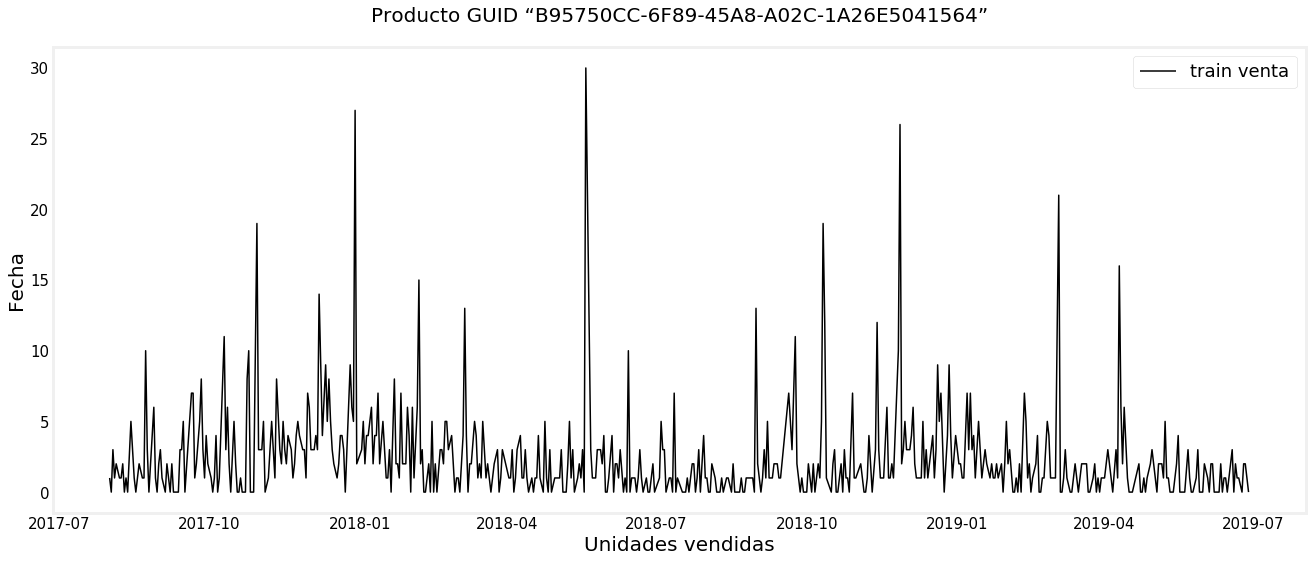

In [16]:
#plot y_train data
plt.plot(y_train, color ="black", label='train venta',linewidth=1.5)
plt.legend()
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(False)
plt.rcParams["figure.facecolor"] ='white'
plt.title('Producto GUID “B95750CC-6F89-45A8-A02C-1A26E5041564”')
plt.ylabel('Fecha')
plt.xlabel('Unidades vendidas')
size=20
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,6),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
plt.show ()

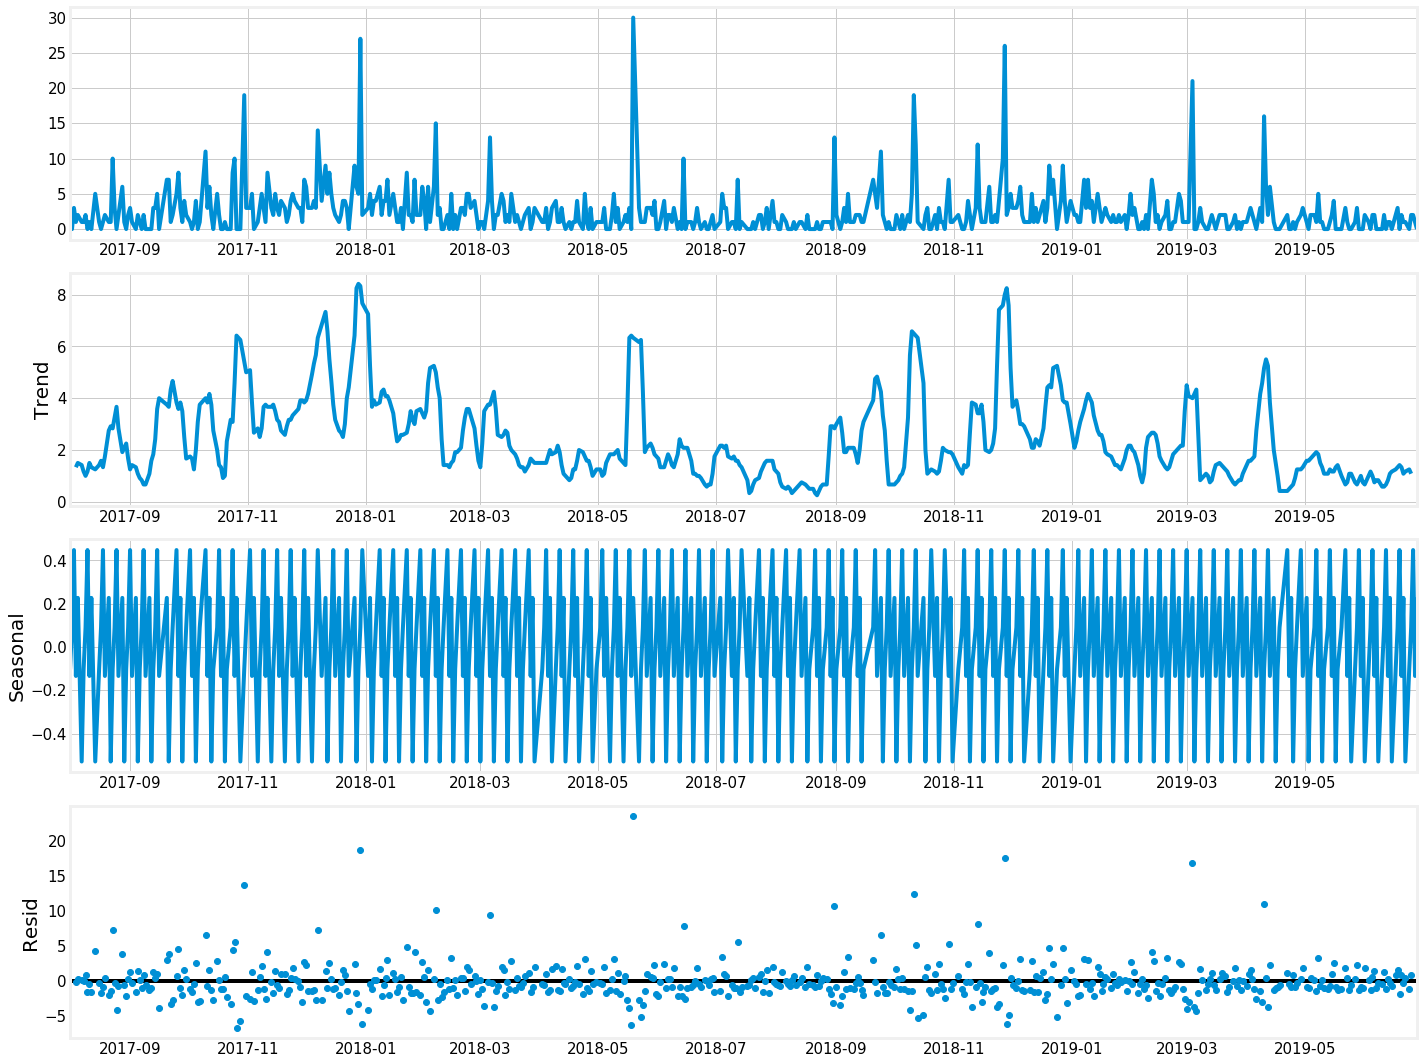

In [4]:
# plot y_train data decompose
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(y_train, model='additive',freq=6)
fig = decomposition.plot()
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] ='white'
plt.grid(False)
plt.rc('font', size=15) 
plt.rc('xtick', labelsize=15)
plt.show()

In [5]:
#fuction for obtain statistics informations
def tsdiag(y, figsize = (14,8), title = "", lags = 10):
    #The data:
    tmp_data = pd.Series(y)
    #The Ljung-Box test results for the first k lags:
    tmp_acor = list(sm_stat.diagnostic.acorr_ljungbox(tmp_data, lags = lags, boxpierce = True))
    # get the p-values
    p_vals = pd.Series(tmp_acor[1])
    #Start the index from 1 instead of 0 (because Ljung-Box test is for lag values from 1 to k)
    p_vals.index += 1
    fig = plt.figure(figsize = figsize)
    #Plot the p-values:
    p_vals.plot(ax = fig.add_subplot(313), linestyle='', marker='o', title = "p-values for Ljung-Box statistic", legend = False)
    #Add the horizontal 0.05 critical value line
    plt.axhline(y = 0.05, color = 'blue', linestyle='--')
    # Annotate the p-value points above and to the left of the vertex
    x = np.arange(p_vals.size) + 1
    for X, Y, Z in zip(x, p_vals, p_vals):
        plt.annotate(round(Z, 4), xy=(X,Y), xytext=(-5, 5), ha = 'left', textcoords='offset points')
    plt.show()
    # Return the statistics:
    col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
    return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))

In [6]:
#fuction for plot statistics informations
def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323),  linewidth=1.1)
    plt.grid(False)
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(324), linewidth=1.1)
    plt.grid(False)
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325), linewidth=0.5) 
    plt.title("QQ Plot")
    plt.grid(False)
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40, normed = 1, linewidth=0.5, color='black')
    plt.title("Histograma")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.grid(False)
    plt.show()

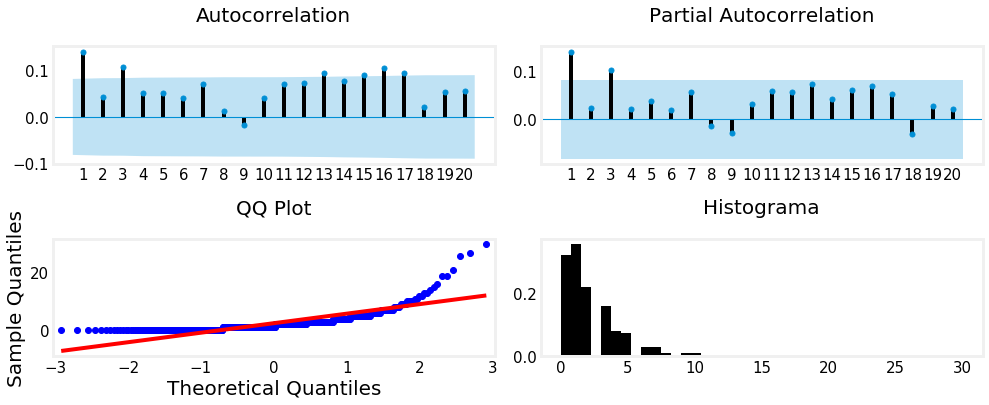

In [7]:
#display information
tsdisplay(y_train.Venta)

In [8]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 6, center = False).mean()
    rol_std = ts.rolling(window = 6, center = False).std()
    plt.plot(ts, color = 'blue',label = 'Data',linewidth=0.8)
    plt.plot(rol_mean, color = 'red', label = 'Media Movil',linewidth=2)
    plt.plot(rol_std, color ='black', label = 'Desviación Estandar Movil',linewidth=2)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Fecha', fontsize = 15)
    plt.ylabel('Venta', fontsize = 15)
    plt.legend(loc='best', fontsize = 15)
    plt.title('Media Movil y Desviación Estandar Movil de la Data', fontsize = 15)
    plt.show(block= True)

In [9]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [10]:
#Adfuller test 
TestStationaryAdfuller(y_train)

Test Statistic                -1.152732e+01
p-value                        3.907460e-21
#Lags Used                     2.000000e+00
Number of Observations Used    5.660000e+02
Critical Value (1%)           -3.441956e+00
Critical Value (5%)           -2.866660e+00
Critical Value (10%)          -2.569497e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [11]:
# Create model for SARIMAX(p,d,q)(P,D,Q)6
def arimamodel(timeserie):
    autoarima_model = pm.auto_arima(y_train, start_p=1, start_q=1,
                             max_p=5, max_q=5, m=6,
                             start_P=2, seasonal=True,
                             d=0, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
    return autoarima_model

In [12]:
# run searching of parameters
arima_model = arimamodel(y_train)
# summary charasteristics of model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(2,1,1)[6] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : AIC=3322.559, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : AIC=3150.781, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[6] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,1,0)[6]             : AIC=3320.560, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[6] intercept   : AIC=3320.683, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[6] intercept   : AIC=3098.482, Time=0.47 sec
 ARIMA(1,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(1,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(2,1,0)[6] intercept   : AIC=3098.890, Time=0.45 sec
 ARIMA(2,0,0)(2,1,0)[6] intercept   : AIC=3100.016, Time=0.58 sec
 ARIMA(1,0,1)(2,1,0)[6] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,0,1)(2,1,0)[6] intercept   : AIC=3098.330, Time=1.40 sec
 ARIMA(0,0,1)(1,1,0)[6] intercept   : AIC=3150.692, Time=0.26 sec
 ARIMA(0,0,1)(2,1,1)[6] intercept   : AIC=inf, Time=1.77 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  569
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 6)   Log Likelihood               -1544.165
Date:                            Sun, 23 Aug 2020   AIC                           3096.331
Time:                                    17:22:56   BIC                           3113.664
Sample:                                         0   HQIC                          3103.097
                                            - 569                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0697      0.042      1.651      0.099      -0.013       0.152
ar.S.L6       -0.6673      0.025    -26.725      0.000      -0.716      -0.618
ar.S.L12      -0.3008      0.022    -13.437      0.000      -0.345      -0.257
sigma2        14.0456      0.306     45.951      0.000      13.447      14.645
===================================================================================
Ljung-Box (Q):                      117.59   Jarque-Bera (JB):              4531.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             2.29
Prob(H) (two-sided):                  0.02   Kurtosis:                        16.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

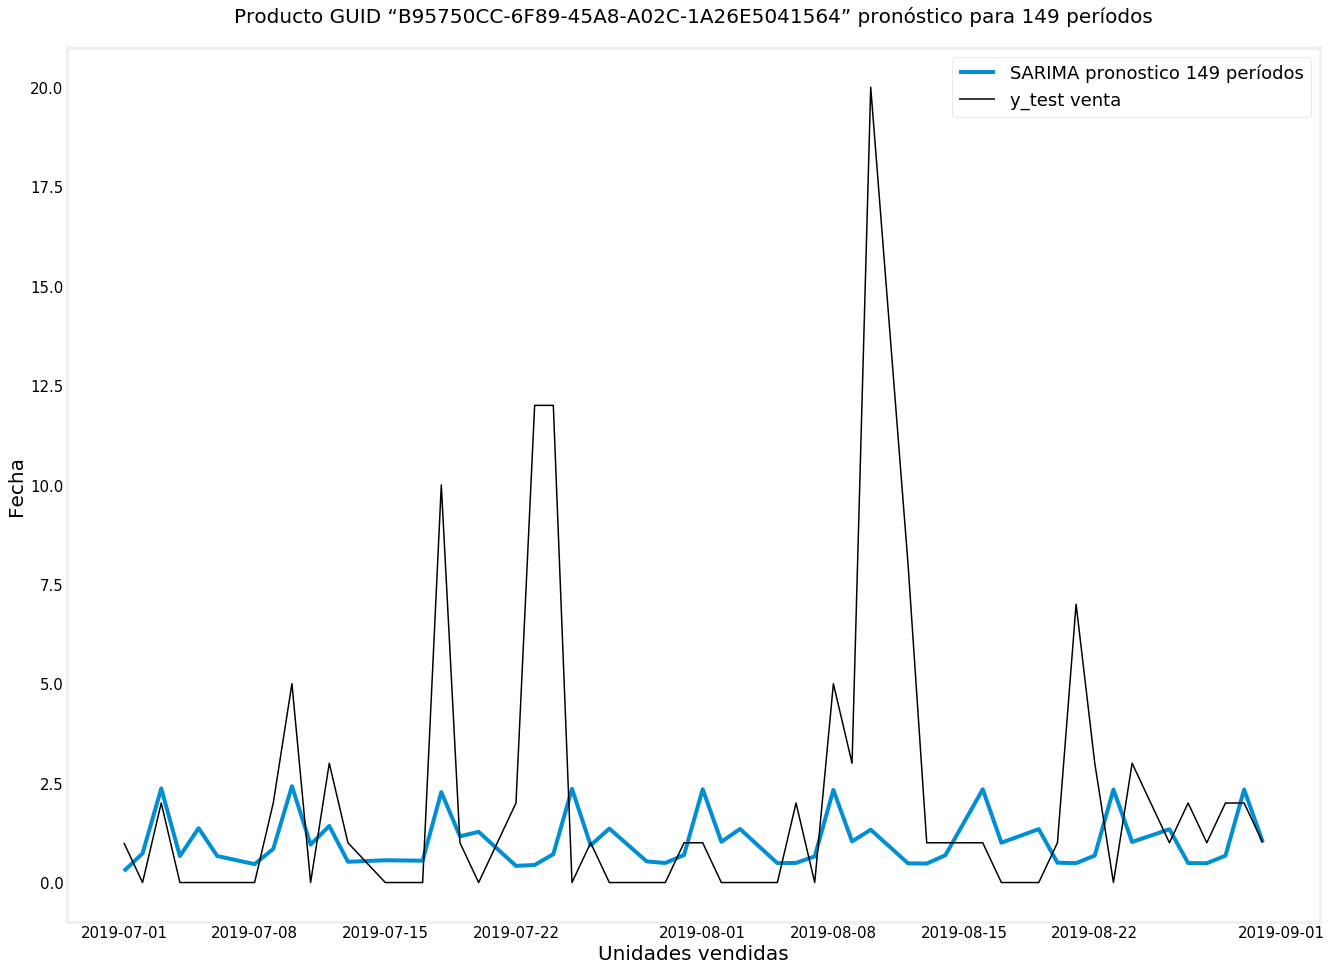

In [13]:
test_array = pd.DataFrame(y_test, columns= ['Venta'])
#with the marameters selected run SARIMAX with y_train data
model=SARIMAX(y_train, order=arima_model.order, seasonal_order=arima_model.seasonal_order)
#fit the model
results = model.fit()
#make predictions
arima_pred = results.get_forecast(len(y_test))
arima_mean = arima_pred.predicted_mean
test_array['pred'] = arima_mean.values.tolist()
#plt.plot(dates, sarima_mean, label='SARIMA')
plt.plot( test_array.pred, label='SARIMA pronostico 149 períodos' ,linewidth=4.0)
plt.plot(test_array.Venta, color ="black", label='y_test venta',linewidth=1.5)
plt.legend()
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(False)
plt.rcParams["figure.facecolor"] ='white'
plt.title('Producto GUID “B95750CC-6F89-45A8-A02C-1A26E5041564” pronóstico para 149 períodos')
plt.ylabel('Fecha')
plt.xlabel('Unidades vendidas')
size=20
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
plt.show ()
test_array.to_csv('test_array.csv')

In [14]:
test_array

,Venta,pred
2019-07-01,1.0,0.287518
2019-07-02,0.0,0.732887
2019-07-03,2.0,2.366443
2019-07-04,0.0,0.665414
2019-07-05,0.0,1.366443
2019-07-06,0.0,0.667293
2019-07-08,0.0,0.462103
2019-07-09,2.0,0.845536
2019-07-10,5.0,2.422768
2019-07-11,0.0,0.954275


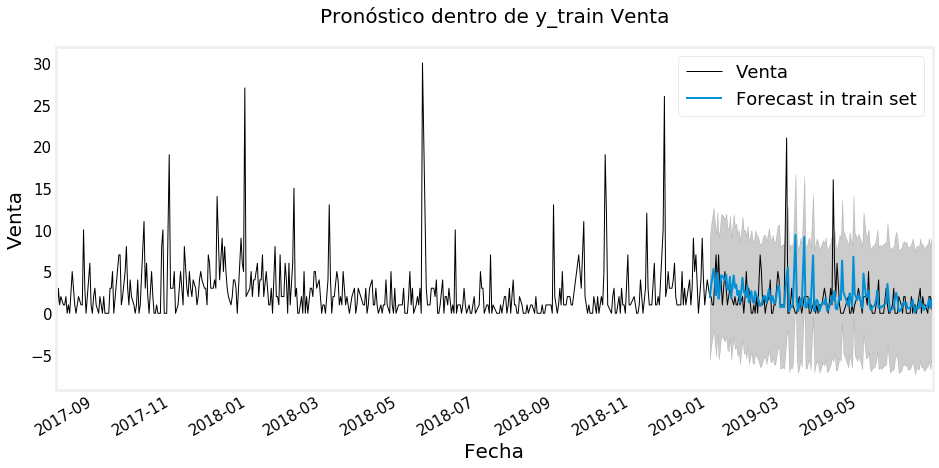

In [15]:
#prediction into y_train
pred = results.get_prediction(start=('2019-01-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_train.plot(label='y_train venta',linewidth=1.0,color ="black")
pred.predicted_mean.plot(ax=ax, label='Forecast in train set', alpha=5, figsize=(14, 7),linewidth=2.0)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Venta')
plt.legend()
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(False)
plt.rcParams["figure.facecolor"] ='white'
size=20
plt.title('Pronóstico dentro de y_train Venta')
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
plt.show()